In [1]:
import util.util_validation as ut_val
import util.util_shape_bias as ut_sb

from util.util_logging import create_distances_md, create_shape_bias_md

In [2]:
exclude_params_dict = {"tag": ["CropSize32", "divergent", "toSlow", "lrAdjust1", "lrAdjust2", "noCosine", "bszAdjust1"]}
keep_params_dict = {"aug": ["colorJitter", "grayscale"]}
models_dict, df_modelNames = ut_val.collect_models_dict(epoch="last", dataset_classifier="", exclude_params_dict=exclude_params_dict, keep_params_dict=keep_params_dict)
print(df_modelNames.to_markdown(index=False))

| model_name                                                             |
|:-----------------------------------------------------------------------|
| CE_animals10_diff_-1+4000_allAug                                       |
| CE_animals10_diff_-1_allAug                                            |
| CE_animals10_diff_4000_allAug                                          |
| SupConHybrid_animals10_diff_-1+4000_cAug                               |
| SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug                        |
| SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug_factor5cAugSameSAug     |
| SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor5 |
| SupCon_animals10_diff_-1+4000_cAugSameSAug                             |
| SupCon_animals10_diff_-1_allAug                                        |


In [3]:
cuda_device = 1

dataset_cue_conflict = "shape_texture_conflict_animals10_many"

dataset_orig = "animals10_diff_-1"
dataset_shape = "stylized_animals10"
dataset_diff = "animals10_diff_4000"

## Validations

### Cue Conflict Shape Bias

Get predictions for shape texture cue conflict dataset


100%|██████████| 897/897 [04:27<00:00,  3.35it/s]


,SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug
shape_bias,0.652331
shape_bias_b,0.652331
acc,0.391034
acc_b,0.391034
acc_shape,0.255084
acc_b_shape,0.255084
acc_texture,0.135950
acc_b_texture,0.135950


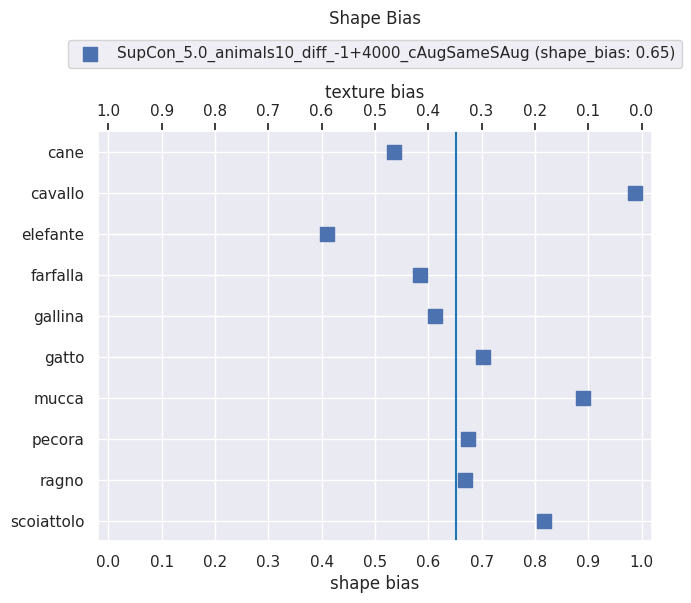

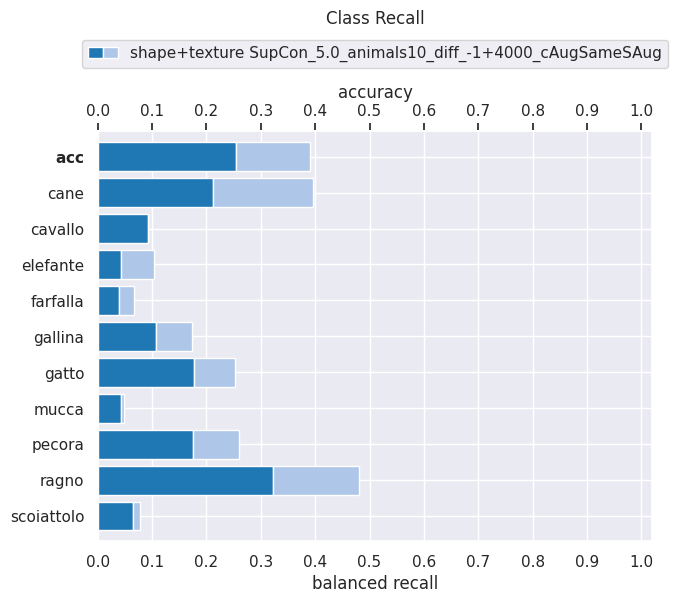

In [7]:
df_biases, class_biases = ut_sb.cue_conflict_shape_bias_metric_for_many(models_dict, dataset_cue_conflict, cuda_device)
ut_sb.save_cue_conflict_shape_bias_to_csv_file_for_many(models_dict, df_biases, class_biases, dataset_cue_conflict, save_plots=True)

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_shape_bias_md(path_folder)

df_biases

### Correlation Coefficient Shape Bias

In [ ]:
df_dimensions = ut_sb.corelation_coefficient_shape_bias_metric_for_many(models_dict, dataset_orig, dataset_shape, cuda_device, separate_color=True, apply_ColorJitter=["texture"])
ut_sb.save_correlation_coefficient_shape_bias_to_csv_file_for_many(models_dict, df_dimensions, dataset_dict={"shape": dataset_shape, "texture": dataset_orig, "color": dataset_orig},
                                                                   apply_ColorJitter=["texture"])

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_shape_bias_md(path_folder)

df_dimensions

#### Form Cue Conflict Dataset

In [ ]:
df_dimensions = ut_sb.corelation_coefficient_shape_bias_metric_from_cue_conflict_dataset_for_many(models_dict, dataset_cue_conflict, cuda_device)
ut_sb.save_correlation_coefficient_shape_bias_to_csv_file_for_many(models_dict, df_dimensions, dataset_dict={"cue_conflict": dataset_cue_conflict})

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_shape_bias_md(path_folder)

df_dimensions

-----------

#### Experiments

In [30]:
model_short_name = "SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug"

root_model = models_dict[model_short_name][0]

embedding_orig, embedding_shape, embedding_texture, class_labels = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, dataset_shape, cuda_device, separate_color=False, apply_ColorJitter=[])
corr_coef_shape = compute_dim_correlation_coefficients(embedding_orig, embedding_shape)
corr_coef_texture = compute_dim_correlation_coefficients(embedding_orig, embedding_texture)

100%|██████████| 202/202 [01:00<00:00,  3.33it/s]


In [71]:
model_short_name = "SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug"

root_model = models_dict[model_short_name][0]

embedding, _, _, _, shapeName_textureName_list = compute_cue_conflict_embeddings(root_model, dataset_cue_conflict, cuda_device)

# determent the shape and texture pairs in the cue conflict embedding
shape_pairs = []
shape_array = np.array([sN for sN,_ in shapeName_textureName_list])
for sN in set(shape_array):
    shape_indices = np.where(shape_array == sN)[0]
    shape_pairs.append(shape_indices)

shape_pair_A = np.concatenate([np.tile(shape_pairs[i], reps=len(shape_pairs[i])-1) for i in range(len(shape_pairs))])
shape_pair_B = np.concatenate([np.concatenate([np.roll(shape_pairs[i], shift=j) for j in range(1,len(shape_pairs[i]))]) for i in range(len(shape_pairs))])

texture_pairs = []
texture_array = np.array([tN for _,tN in shapeName_textureName_list])
for tN in set(texture_array):
    texture_indices = np.where(texture_array == tN)[0]
    texture_pairs.append(texture_indices)

texture_pair_A = np.concatenate([np.tile(texture_pairs[i], reps=len(texture_pairs[i])-1) for i in range(len(texture_pairs))])
texture_pair_B = np.concatenate([np.concatenate([np.roll(texture_pairs[i], shift=j) for j in range(1,len(texture_pairs[i]))]) for i in range(len(texture_pairs))])

corr_coef_shape_2 = compute_dim_correlation_coefficients(embedding[shape_pair_A], embedding[shape_pair_B])
corr_coef_texture_2 = compute_dim_correlation_coefficients(embedding[texture_pair_A], embedding[texture_pair_B])

100%|██████████| 897/897 [04:06<00:00,  3.64it/s]


In [185]:
model_short_name = "SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug"

root_model = models_dict[model_short_name][0]

_, embedding_diff_4000, _, class_labels = compute_load_orig_shape_texture_embeddings(root_model, dataset_orig, "animals10_diff_4000", cuda_device, separate_color=False, apply_ColorJitter=["shape"])
corr_coef_diff_4000 = compute_dim_correlation_coefficients(embedding_orig, embedding_diff_4000)

100%|██████████| 202/202 [01:01<00:00,  3.30it/s]


In [201]:
eps = 0.0

argsort_shape = np.argsort(corr_coef_shape)
argsort_texture = np.argsort(corr_coef_texture)

argsort_shape_2 = np.argsort(corr_coef_shape_2)
argsort_texture_2 = np.argsort(corr_coef_texture_2)

argsort_diff_4000 = np.argsort(corr_coef_diff_4000)

larger_shape_corr_coef_A = (corr_coef_shape - eps > corr_coef_texture).astype(int)
larger_shape_corr_coef_B = (corr_coef_shape_2 - eps > corr_coef_texture_2).astype(int)
larger_shape_corr_coef_C = (corr_coef_shape - eps > corr_coef_texture_2).astype(int)
larger_shape_corr_coef_D = (corr_coef_shape_2 - eps > corr_coef_texture).astype(int)
larger_shape_corr_coef_E = (corr_coef_diff_4000 - eps > corr_coef_texture).astype(int)
larger_shape_corr_coef_F = (corr_coef_diff_4000 - eps > corr_coef_texture_2).astype(int)

larger_texture_corr_coef_A = (corr_coef_shape + eps < corr_coef_texture).astype(int)
larger_texture_corr_coef_B = (corr_coef_shape_2 + eps < corr_coef_texture_2).astype(int)
larger_texture_corr_coef_C = (corr_coef_shape + eps < corr_coef_texture_2).astype(int)
larger_texture_corr_coef_D = (corr_coef_shape_2 + eps < corr_coef_texture).astype(int)
larger_texture_corr_coef_E = (corr_coef_diff_4000 + eps < corr_coef_texture).astype(int)
larger_texture_corr_coef_F = (corr_coef_diff_4000 + eps < corr_coef_texture_2).astype(int)

shape_larger_A = (larger_shape_corr_coef_A == 1).sum()
texture_larger_A = (larger_texture_corr_coef_A == 1).sum()

shape_larger_B = (larger_shape_corr_coef_B == 1).sum()
texture_larger_B = (larger_texture_corr_coef_B == 1).sum()

shape_larger_ABCD = (larger_shape_corr_coef_A + larger_shape_corr_coef_B + larger_shape_corr_coef_C + larger_shape_corr_coef_D == 4).sum()
texture_larger_ABCD = (larger_texture_corr_coef_A + larger_texture_corr_coef_B + larger_texture_corr_coef_C + larger_texture_corr_coef_D == 4).sum()

shape_larger_E = (larger_shape_corr_coef_E == 1).sum()
texture_larger_E = (larger_texture_corr_coef_E == 1).sum()

shape_larger_ABCDEF = (larger_shape_corr_coef_A + larger_shape_corr_coef_B + larger_shape_corr_coef_C + larger_shape_corr_coef_D + larger_shape_corr_coef_E +larger_shape_corr_coef_F == 6).sum()
texture_larger_ABCDEF = (larger_texture_corr_coef_A + larger_texture_corr_coef_B + larger_texture_corr_coef_C + larger_texture_corr_coef_D + larger_texture_corr_coef_E + larger_texture_corr_coef_F == 6).sum()

print(f"A: shape: {shape_larger_A}, texture: {texture_larger_A}   {estimate_dims([corr_coef_shape, corr_coef_texture])}")

print(f"\nB: shape: {shape_larger_B}, texture: {texture_larger_B}   {estimate_dims([corr_coef_shape_2, corr_coef_texture_2])}")

print(f"\nABCD: shape: {shape_larger_ABCD}, texture: {texture_larger_ABCD}")

print(f"\nE: shape: {shape_larger_E}, texture: {texture_larger_E}   {estimate_dims([corr_coef_diff_4000, corr_coef_texture])}")

print(f"\nABCDEF: shape: {shape_larger_ABCDEF}, texture: {texture_larger_ABCDEF}")

A: shape: 230, texture: 282   [128, 131, 253]

B: shape: 36, texture: 476   [104, 157, 251]

ABCD: shape: 13, texture: 249

E: shape: 512, texture: 0   [198, 107, 207]

ABCDEF: shape: 13, texture: 0


### Feature Embedding Distances

In [7]:
df_distances = ut_sb.compute_distance_to_diff_for_many(models_dict, dataset_orig, dataset_diff, cuda_device, plot_hist=False)
ut_sb.save_dist_to_csv_file_for_many(models_dict, df_distances, dataset_orig, dataset_diff)

for m in models_dict:
    root_model, _ = models_dict[m]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    create_distances_md(path_folder)

df_distances

100%|██████████| 5236/5236 [00:59<00:00, 87.53it/s] 


,SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug
mean_distance_related,0.013292
std_distance_related,0.011652
mean_distance_classes,0.282632
std_distance_classes,0.124335
mean_distance_all_vs_all,0.382120
std_distance_all_vs_all,0.121242
min_distance,0.000563
max_distance,0.948391
